# Project 4

In this project, you will summarize and present your analysis from Projects 1-3.

### Intro: Problem Statement / Specific Aim

This project's goal is to identify the various factors that may influence admission into graduate school.  Specifically, I hypothesize that there does exist an association between graduate school admission rates and the prestige of undergraduate schools, namely a positive one.  This might not be a direct association, but instead be representative of some underlying variable like student study habits, IQ, etc.  

### Dataset:  Description of your data and any cleaning that was completed

For this project, I used the data set provided by UCLA's Logit Regression in R tutorial.  Provided in .CSV format, it contains five different features, of which the latter four we'll be using as predictor variables: admission (a binary variable, admit=1 / not admit=0), gre (the GRE score), gpa (with values 0.0-4.0), and rank (the applicant's undergraduate alma mater rank, with 1=highest to 4=lowest).

First, I loaded the python libraries I will be needing.

In [1]:
#imports
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab as pl
import numpy as np
%matplotlib inline

/Users/mundyreimer/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


This is followed up with reading in the .CSV's data into a data frame.  

In [3]:
#Read in data from source 
df_raw = pd.read_csv("../assets/admissions.csv")
print(df_raw.head())

   admit    gre   gpa  prestige
0      0  380.0  3.61       3.0
1      1  660.0  3.67       3.0
2      1  800.0  4.00       1.0
3      1  640.0  3.19       4.0
4      0  520.0  2.93       4.0


To begin the initial stages of the exploratory data analysis (EDA) phase of the project, it's good practice to get a sense of the shape & size of our data frame.

In [7]:
print(len(df_raw))
print(df_raw.shape)
print(df_raw.count())

400
(400, 4)
admit       400
gre         398
gpa         398
prestige    399
dtype: int64


To continue with the EDA phase of the project, a table is provided below that gives the summary statistics of the raw data.

In [65]:
df_raw.describe()

,admit,gre,gpa,prestige
count,400.000000,398.000000,398.00000,399.000000
mean,0.317500,588.040201,3.39093,2.486216
std,0.466087,115.628513,0.38063,0.945333
min,0.000000,220.000000,2.26000,1.000000
25%,0.000000,520.000000,3.13000,2.000000
50%,0.000000,580.000000,3.39500,2.000000
75%,1.000000,660.000000,3.67000,3.000000
max,1.000000,800.000000,4.00000,4.000000


This was then rearranged into two columns explaining the corresponding summary statistics by admission status.

### Table giving data by admission status

In [66]:
pd.crosstab(df_raw['prestige'], 
                  [df_raw['admit'], df_raw['gpa'].mean(), df_raw['gre'].mean()],
                 colnames=['Admit','Mean GPA','Mean GRE'])

Admit,0,1
Mean GPA,3.39093,3.39093
Mean GRE,588.040201,588.040201
prestige,,
1.0,28,33
2.0,97,53
3.0,93,28
4.0,55,12


Next, I will need to drop data points with any missing data.  The data frame will be shown again to make sure the summary statistics stay intact.

In [64]:
df = df_raw.dropna()
print(df.count())
df.describe()

admit       397
gre         397
gpa         397
prestige    397
dtype: int64


,admit,gre,gpa,prestige
count,397.000000,397.000000,397.000000,397.000000
mean,0.317380,587.858942,3.392242,2.488665
std,0.466044,115.717787,0.380208,0.947083
min,0.000000,220.000000,2.260000,1.000000
25%,0.000000,520.000000,3.130000,2.000000
50%,0.000000,580.000000,3.400000,2.000000
75%,1.000000,660.000000,3.670000,3.000000
max,1.000000,800.000000,4.000000,4.000000


I then plotted the histograms giving the distribution of each variable.

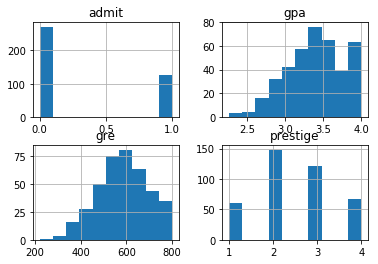

In [68]:
# plot the distribution of each variable 
df.hist()
pl.show()

From the above histograms, we can see that we meet the normal distribution requirements.  Although GPA and gre are slightly skewed towards the upper ranges, we do not need to correct for anything.

Out of concern for possible problems that might arise due to collinearity, I created a correlation matrix.  We can see that the aforementioned is of no concern in this case.

In [69]:
# create a correlation matrix for the data
df.corr()

,admit,gre,gpa,prestige
admit,1.000000,0.181202,0.174116,-0.243563
gre,0.181202,1.000000,0.382408,-0.124533
gpa,0.174116,0.382408,1.000000,-0.060976
prestige,-0.243563,-0.124533,-0.060976,1.000000


### Methods: 

In the first step of our actual data analysis, I needed to sort our data into mutually exclusive categories.  The data that I'll be sorting or "dummifying" is the predictor variable, "prestige".  In the modeling phase, we need in general n-1, or in this instance 3 class/dummy variables. The last dummy variable will become our reference.

In [84]:
# dummify rank
dummy_ranks = pd.get_dummies(df['prestige'], prefix='prestige')
dummy_ranks.head()

,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,0,0,0,1
4,0,0,0,1


This required rearranging of the table to merge the new dummy variables into the original data frame, cut out the reference variable from the prestige labels, and add an intercept value.

In [86]:
# create a clean data frame for the regression
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2':])
print(data.head())

# manually add the intercept
data['intercept'] = 1.0

   admit    gre   gpa  prestige_2.0  prestige_3.0  prestige_4.0
0      0  380.0  3.61             0             1             0
1      1  660.0  3.67             0             1             0
2      1  800.0  4.00             0             0             0
3      1  640.0  3.19             0             0             1
4      0  520.0  2.93             0             0             1


After cleaning the data, we can now being the modeling step to check whether being admitted to grad school was associated with the applicant attending a rank #1 undergraduate institution.  This modeling phase first requires to build a training set, training the model, fitting the model, and then obtaining the results.

In [90]:
#building the training set 
train_cols = data.columns[3:]

#training the model 
logit = sm.Logit(data['admit'], data[train_cols])

#fitting the model
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.593375
         Iterations 5


### Visuals: Provide a table or visualization of these results

In [91]:
 print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  397
Model:                          Logit   Df Residuals:                      393
Method:                           MLE   Df Model:                            3
Date:                Mon, 04 Dec 2017   Pseudo R-squ.:                 0.05042
Time:                        15:47:15   Log-Likelihood:                -235.57
converged:                       True   LL-Null:                       -248.08
                                        LLR p-value:                 1.533e-05
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
prestige_2.0    -0.7479      0.309     -2.421      0.015      -1.353      -0.142
prestige_3.0    -1.3647      0.335     -4.069      0.000      -2.022      -0.707
prestige_4.0    -1.6867      0.409     -4.12

I've also printed out the results of the confidence interval for each coefficient.  This should give an idea for how robust each of the predictor variables (various rankings or prestige values) are.  

In [87]:
result.conf_int()

,0,1
prestige_2.0,-1.353297,-0.142479
prestige_3.0,-2.022044,-0.707352
prestige_4.0,-2.488957,-0.884502
intercept,-0.339287,0.667893


### Results: 

In interpreting our above model's results, we can see that the probability of being accepted into a graduate program is indeed higher for students who have previously attended a highly prestigious undergraduate school.

In order to get a feel for how much the predictor variables of prestige affects the odds of being admitted, we need to calculate the odds ratios, or how much one unit of change in the predictor variable affects the odds of being admitted.  Given that this is a logistic model, we need to use the exponential function to interpret the results.

In [89]:
print(np.exp(result.params))

prestige_2.0    0.473365
prestige_3.0    0.255458
prestige_4.0    0.185124
intercept       1.178571
dtype: float64


### Discussion & Future steps:

In summary, from the above model, we do see an association between the probability of being accepted into a graduate program and the applicant's prior attendance at a prestigious alma mater.  In this case, we see that the higher the prestige, the greater the odds of being accepted into a graduate program.  

To further the above analysis, it would be wise to compare the above model with other models.  This would let us compare model performance to see if the relationship holds or to elucidate any further insights.  We can also check to see whether or not the logistic model was even needed, when a simpler linear model might of exhibited the same relationship.  Furthermore, we could go into depth in each of the models (including this one) to change which one of our predictor variables becomes the reference variable, as well as try out the model on different sets of predictor variables.  This might allow us to further explore any possible confounders or multi-collinearity issues that might have arisen in the plotting of the correlation matrix. 